# Results of training a neural network for classification

In this notebook I take a look at results from training a neural network (NN).

I have already run 'exp/nn_clf_weightdecay_mort_07/train_model.py'. This script prepares training and validation data. A NN is trained on training data for different hyperparameters (weight decay) to make a classification. Each trained model is rated on a validation set. The fitted encoder and the trained model are saved as well as training and validation losses.

The model uses the following data as a predictor:
- prescribed drugs (from first 24 hours of admission)
- diagnosis at admisson
- age at admission
- admission type
- admission location
- marital status
- insurance

It predicts mortality within the first 14 days from admission. For recently admitted patients this information reflects how critifal the status of a patient is.

In [1]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from prep import PrepareDataV2
import prep.utils as utils

## Preparation of test data

I start by getting the test data, loading the encoder (which was fitted for the training data), and preparing the predictors and targets.

In [2]:
# PREPARE TEST DATA
dtype = torch.float
device = torch.device("cpu")

# load test data
tables = ['admissions', 'patients', 'prescriptions']
data_test = PrepareDataV2(name='test', root='../data/test')
data_test.load_table_pickle_list(tables)

# load encoder
pat_enc = pickle.load(open('nn_clf_weightdecay_mort_07/encoder.p', 'rb'))

# prepare predictors
x_test, hadm_id_map_test = pat_enc.transform(data_test.prescriptions,
                                             data_test.admissions,
                                             data_test.patients)
x_test = x_test.astype(np.float)
x_test_t = torch.tensor(x_test, device=device, dtype=dtype)

# prepare targets
y_test = utils.patient_alive_after_duration(data_test.admissions, data_test.patients, hadm_id_map_test)
y_test = y_test.astype(np.uint8)
y_test_t = torch.tensor(y_test, device=device, dtype=torch.long).squeeze()

## Find optimal hyper parameter for regularization

The chosen model is a neural net with two linear layers. The model is regularized by two dropout layers with dropout percentage of 20%. In addition the model is restricted by weight decay with varied regularization parameter. Opimization is performed with Adam optimzier.

In [3]:
ROC_AUC = pd.read_csv('nn_clf_weightdecay_mort_07/results_val_ROC_AUC__.csv')

Text(0, 0.5, 'ROC AUC score')

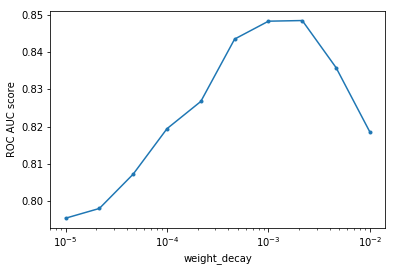

In [4]:
plt.semilogx(ROC_AUC['weight_decay'], ROC_AUC['roc_list'], marker='.')
plt.xlabel('weight_decay')
plt.ylabel('ROC AUC score')

In [5]:
ROC_AUC.sort_values(by='roc_list', ascending=False).head(3)

,weight_decay,roc_list
7,0.002154,0.848427
6,0.001000,0.848253
5,0.000464,0.843465


The model was trained for ten different weight decay parameters, over several powers of 10. The diagram shows the area under the ROC curve with regard to the validation data. Its optimum is reached for a weight_decay of 0.001, and the corresponding AUC values is 0.85 .

Now, I load the model that performed best on the validation data and apply it to the test data.

In [6]:
# load the best model (with regrad to validation data)
model = torch.load('nn_clf_weightdecay_mort_07/results_0.001_/NN_Clf_mort.pt')
model.eval()

y_test_predict_proba = model.predict_proba(x_test_t)
y_test_predict = model.predict(x_test_t)
auc_test = roc_auc_score(y_test, y_test_predict_proba[:, 1])
print('test AUC-ROC: ' + str(auc_test))

test AUC-ROC: 0.8542604721147016


The model also delivers an AUC of 0.85 on the test data. But what does an AUC of 0.85 mean?

In [7]:
# Confusion matrix
pd.DataFrame(confusion_matrix(1-y_test, 1-y_test_predict),
             columns = ['pred. neg.', 'pred. pos'],
             index = ['neg', 'pos'])

,pred. neg.,pred. pos
neg,10777,30
pos,814,175


Above, I have plotted the confusion matrix.

- negative = patient alive after 14 days
- positve = patient will pass away within 14 days from admission


The confusion matrix tells us that 9% of all patients pass away within the first 14 days from admission.


The true negative rate (TNR = TN / N) is 99.7%, meaning that 99.7% of the patients who will survive are classified correctly.

On the other hand the true positive rate (TPR = TP / P) is 17.6%, meaning that 17.6% of the patients who will pass away are classified correctly.

From the group of patients, that are predicted to survive, 93% actually survive.
From the group of patients, that are predicted to pass away, 86% actually pass away.

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(1 - y_test, 1 - y_test_predict_proba[:,1])

(0, 1)

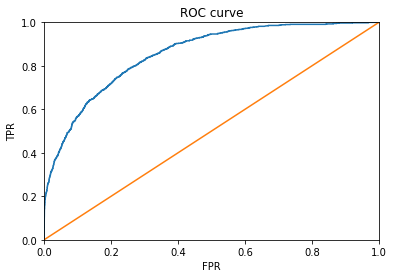

In [32]:
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1] )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.xlim([0,1])
plt.ylim([0,1])

Above, the ROC curve of the best model is plotted with respect to the test data. It tells us, that the model actually not only provides us with a classification (0 or 1), but it also returns a probability for the classes. If we shift the treshold value for classification, we can increase the true positive rate (TPR) while in parallel increasing the false positive rate (FPR = 1 - TNR).

In [8]:
# Alternative threshold
y_pred_alt = (y_test_predict_proba[:, 1]>0.935) #0.82
pd.DataFrame(confusion_matrix(1-y_test, 1-y_pred_alt),
             columns = ['pred. neg.', 'pred. pos'],
             index = ['neg', 'pos'])

,pred. neg.,pred. pos
neg,7825,2982
pos,190,799


Here, I have set an alternative threshold. 

## Loss during training

### Best regularization

In [9]:
loss_train = pd.read_csv('nn_clf_weightdecay_mort_07/results_0.001_/errors_train__NN_Clf_mort__.csv')
loss_val = pd.read_csv('nn_clf_weightdecay_mort_07/results_0.001_/errors_val__NN_Clf_mort__.csv')

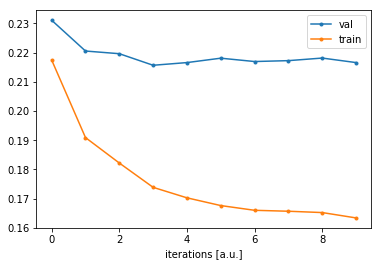

In [10]:
plt.plot(loss_val, marker = '.', label = 'val')
plt.plot(loss_train, marker = '.', label = 'train')
plt.xlabel('iterations [a.u.]')
plt.legend()

During training the loss (CrossEntropyLoss) is calculated every 10 epochs for the training data and for the validation data. Evaluation mode of the model is used for swichting the dropout layers to correct mode.

### Underfitting

In [11]:
loss_train_underfit = pd.read_csv('nn_clf_weightdecay_mort_07/results_0.004641588833612777_/errors_train__NN_Clf_mort__.csv')
loss_val_underfit = pd.read_csv('nn_clf_weightdecay_mort_07/results_0.004641588833612777_/errors_val__NN_Clf_mort__.csv')

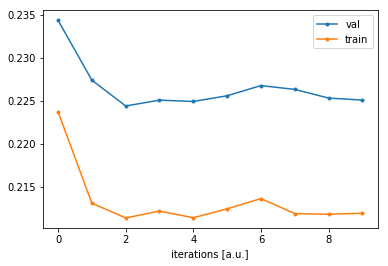

In [12]:
plt.plot(loss_val_underfit, marker = '.', label = 'val')
plt.plot(loss_train_underfit, marker = '.', label = 'train')
plt.xlabel('iterations [a.u.]')
plt.legend()

The training and the validation loss converge, but at a higher niveau than for optimal weight decay parameter.

### Overfitting

In [13]:
loss_train_overfit = pd.read_csv('nn_clf_weightdecay_mort_07/results_1e-05_/errors_train__NN_Clf_mort__.csv')
loss_val_overfit = pd.read_csv('nn_clf_weightdecay_mort_07/results_1e-05_/errors_val__NN_Clf_mort__.csv')

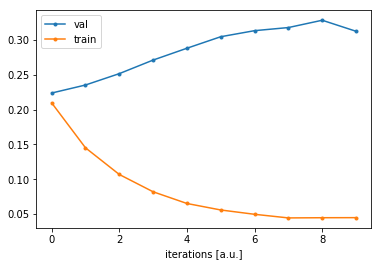

In [14]:
plt.plot(loss_val_overfit, marker = '.', label = 'val')
plt.plot(loss_train_overfit, marker = '.', label = 'train')
plt.xlabel('iterations [a.u.]')
plt.legend()

While the training loss keeps decreasing, the validation loss rises.